## Forecasting Microsoft Stock Market Value
Predicting future stock market values is a very popular time series problem for machine learning. In this project, I shall attempt to build two LTSM models. One for predicting one-step ahead, and one for multi-steps ahead. The Microsoft stock market data comes from the Huge Stock Market Dataset, containing years of historical stock market data for all US-based stocks. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM

In [2]:
data = pd.read_csv("msft.us.txt")
print(data.shape)
data.head()

(7983, 7)


,Date,Open,High,Low,Close,Volume,OpenInt
0,1986-03-13,0.06720,0.07533,0.06720,0.07533,1371330506,0
1,1986-03-14,0.07533,0.07533,0.07533,0.07533,409569463,0
2,1986-03-17,0.07533,0.07533,0.07533,0.07533,176995245,0
3,1986-03-18,0.07533,0.07533,0.07533,0.07533,90067008,0
4,1986-03-19,0.07533,0.07533,0.07533,0.07533,63655515,0


There are 7983 days recorded for Microsoft's stock market values in this dataset. The days are not perfectly consecutive in the dataset, as some days are missing. Hopefully this will not significantly affect the model's accuracy.

In [3]:
data["Date"] = pd.to_datetime(data["Date"])
data = data.drop(["OpenInt"], axis=1)
data.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Thankfully there are no missing values in the dataset, so no data cleaning is required here.

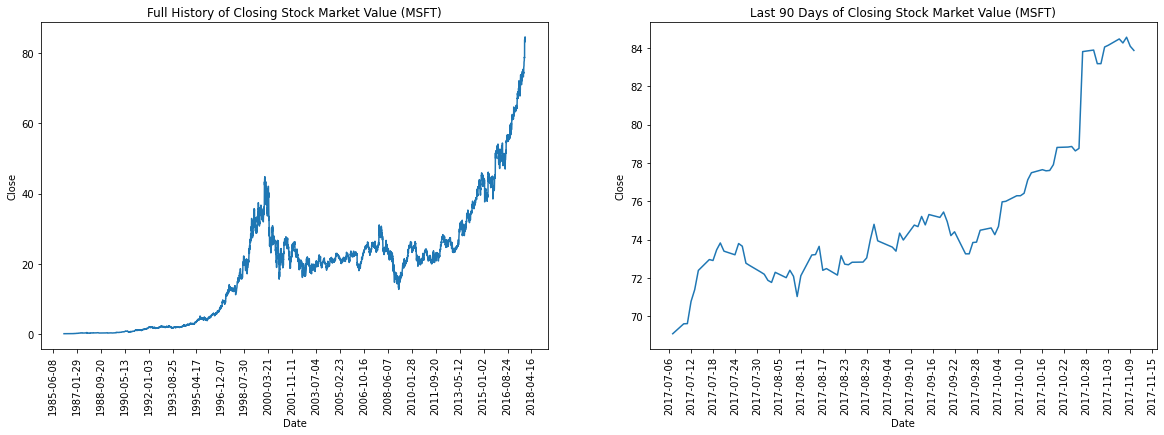

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(x="Date", y="Close", data=data, ax=ax[0])
ax[0].xaxis.set_major_locator(ticker.MaxNLocator(nbins=25))
ax[0].set_title("Full History of Closing Stock Market Value (MSFT)")

sns.lineplot(x="Date", y="Close", data=data[-90:], ax=ax[1])
ax[1].xaxis.set_major_locator(ticker.MaxNLocator(nbins=25))
ax[1].set_title("Last 90 Days of Closing Stock Market Value (MSFT)")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=90)

A bit of data visualisation here shows how Microsoft's closing stock market value has changed over the last ~30 years. We can also see here the last 90 days of closing values recorded in this dataset. The data only goes up until the end of 2017.

# One-Step LTSM Model

In [5]:
WINDOW_LENGTH = 60

The window length determines how many previous days of historical data will be used for the model to make predictions. For the one-step model, in order to predict the closing value on a certain day, the model will use the previous 60 days of data.

In [6]:
split_timestamp = data[-(WINDOW_LENGTH * 2) - 1:]["Date"].iloc[0]

train = data[data["Date"] < split_timestamp]
test = data[data["Date"] >= split_timestamp]

train = train.set_index("Date")
test = test.set_index("Date")

In [7]:
train_values = train.values
test_values = test.values

train_mean = train_values.mean(axis=0)
train_std = train_values.std(axis=0)

train_scaled = (train_values - train_mean) / train_std
test_scaled = (test_values - train_mean) / train_std

In [8]:
x_train = []
for i in range(WINDOW_LENGTH, train.shape[0] - 1):
    x_train.append(train_scaled[(i - WINDOW_LENGTH):i].copy())
x_train = np.array(x_train)
y_train = train_scaled[WINDOW_LENGTH + 1:, 3]
print("X train shape: ", x_train.shape)
print("y train shape: ", y_train.shape)


x_test = []
for i in range(WINDOW_LENGTH, test.shape[0] - 1):
    x_test.append(test_scaled[(i - WINDOW_LENGTH):i].copy())
x_test = np.array(x_test)
y_test = test_scaled[WINDOW_LENGTH + 1:, 3]
print("X test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (7801, 60, 5)
y train shape:  (7801,)
X test shape:  (60, 60, 5)
y test shape:  (60,)


In [9]:
model = Sequential()
model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(25))
model.add(Dense(1))

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                11200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 12,501
Trainable params: 12,501
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(x_train, y_train, batch_size=32, epochs=25, shuffle=True, verbose=0)

Train MAE: 0.02353135777393677
Test MAE: 0.05377512167193788


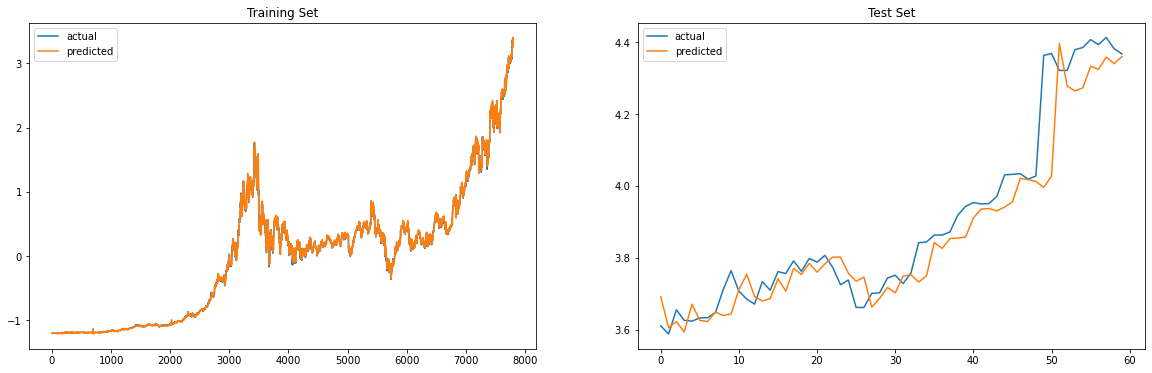

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

y_pred = model.predict(x_train)
ax[0].plot(y_train, label="actual")
ax[0].plot(y_pred, label="predicted")
ax[0].set_title("Training Set")

mae = mean_absolute_error(y_train, y_pred)
print('Train MAE: {}'.format(mae))

y_pred = model.predict(x_test)
ax[1].plot(y_test, label="actual")
ax[1].plot(y_pred, label="predicted")
ax[1].set_title("Test Set")

mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: {}'.format(mae))

for ax in fig.axes:
    plt.sca(ax)
    plt.legend()
plt.show()

With the one-step model, we can see an impressive level of accuracy here. The model's predictions closely resembles the line of the actual closing value. It has also fit nicely to the training data with a very low Mean Absolute Error value. 

# Multi-Step LTSM Model

In [12]:
WINDOW_LENGTH = 60
TARGET_LENGTH = 10

For the multi-step model, we are no longer predicting the closing value for just one day, but multiple days in the future at once. A target length of 10 means the model needs to predict the closing value for the next 10 days, using 50 days of historical data.

In [13]:
x_train = []
y_train = []
for i in range(WINDOW_LENGTH, train.shape[0] - TARGET_LENGTH):
    x_train.append(train_scaled[(i - WINDOW_LENGTH):i].copy())
    y_train.append(train_scaled[i:(i + TARGET_LENGTH), 3].copy())
x_train = np.array(x_train)
y_train = np.array(y_train)
print("X train shape: ", x_train.shape)
print("y train shape: ", y_train.shape)

x_test = []
y_test = []
for i in range(WINDOW_LENGTH, test.shape[0] - TARGET_LENGTH):
    x_test.append(test_scaled[(i - WINDOW_LENGTH):i].copy())
    y_test.append(test_scaled[i:(i + TARGET_LENGTH), 3].copy())
x_test = np.array(x_test)
y_test = np.array(y_test)
print("X test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)

X train shape:  (7792, 60, 5)
y train shape:  (7792, 10)
X test shape:  (51, 60, 5)
y test shape:  (51, 10)


In [14]:
model = Sequential()
model.add(LSTM(200, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(100))
model.add(Dense(TARGET_LENGTH))

model.compile(loss="mae", optimizer="adam")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               164800    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 185,910
Trainable params: 185,910
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(x_train, y_train, batch_size=32, epochs=25, shuffle=True, verbose=2)

Epoch 1/25
244/244 - 1s - loss: 0.0654
Epoch 2/25
244/244 - 1s - loss: 0.0456
Epoch 3/25
244/244 - 1s - loss: 0.0418
Epoch 4/25
244/244 - 1s - loss: 0.0413
Epoch 5/25
244/244 - 1s - loss: 0.0414
Epoch 6/25
244/244 - 1s - loss: 0.0391
Epoch 7/25
244/244 - 1s - loss: 0.0391
Epoch 8/25
244/244 - 1s - loss: 0.0393
Epoch 9/25
244/244 - 1s - loss: 0.0389
Epoch 10/25
244/244 - 2s - loss: 0.0394
Epoch 11/25
244/244 - 1s - loss: 0.0382
Epoch 12/25
244/244 - 1s - loss: 0.0376
Epoch 13/25
244/244 - 1s - loss: 0.0380
Epoch 14/25
244/244 - 1s - loss: 0.0388
Epoch 15/25
244/244 - 1s - loss: 0.0374
Epoch 16/25
244/244 - 1s - loss: 0.0378
Epoch 17/25
244/244 - 1s - loss: 0.0386
Epoch 18/25
244/244 - 1s - loss: 0.0380
Epoch 19/25
244/244 - 1s - loss: 0.0372
Epoch 20/25
244/244 - 1s - loss: 0.0382
Epoch 21/25
244/244 - 1s - loss: 0.0382
Epoch 22/25
244/244 - 1s - loss: 0.0378
Epoch 23/25
244/244 - 1s - loss: 0.0377
Epoch 24/25
244/244 - 1s - loss: 0.0369
Epoch 25/25
244/244 - 1s - loss: 0.0375


In [16]:
y_pred = model.predict(x_train)
mae = mean_absolute_error(y_train, y_pred)
print('Train MAE: {}'.format(mae))

y_pred = model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: {}'.format(mae))

Train MAE: 0.037929688978148544
Test MAE: 0.10806532274089245


In [17]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))

    plt.plot(np.arange(-WINDOW_LENGTH, 0), history[:, 3], label='History')
    plt.plot(np.arange(TARGET_LENGTH), true_future, 'bo', label='True Future')
    plt.plot(np.arange(TARGET_LENGTH), prediction, 'ro', label='Predicted Future')
    plt.legend()
    plt.show()

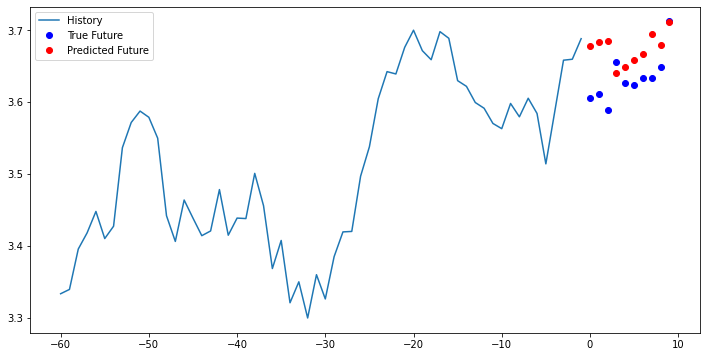

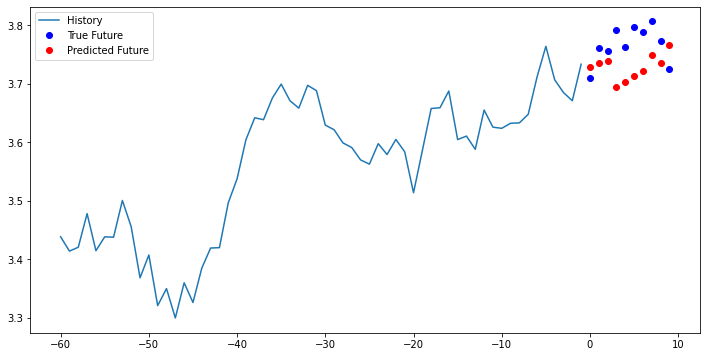

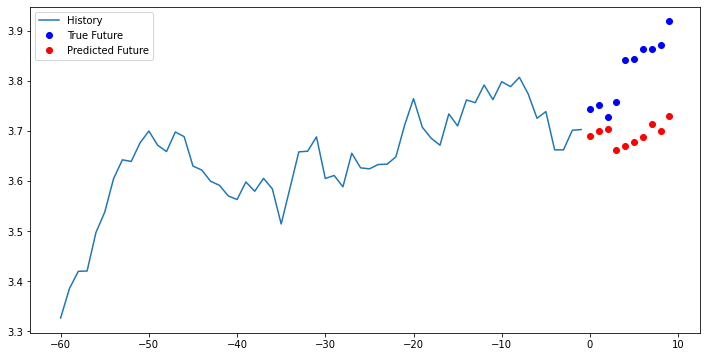

In [18]:
for i in [0, 15, 30]:
    multi_step_plot(x_test[i], y_test[i], y_pred[i])

From these plots we can see that the multi-step model cannot predict the future 10 days very well. The MAE of the test is double that of the one-step model, and we can clearly see from the three graphs above that the multi-step model struggles to accurately predict a 30 days into the future. In fact it's prediction seems to always been a very similar shape.

# Conclusion

In general, Deep Learning models still lag behind old statistical methods like ARIMA when it comes to time series analysis and predicting future forecasts. From this project, I can clearly see that the one-step model appears to perform quite well at predicting the next day's closing value. However the multi-step model is quite a mess at predicting the next 10 days of closing values. The test MAE of the multi-step model is higher than that of the one-step model, and you can clearly see quite a difference in the graphs above. However using MAE as a scoring metric may not be very useful for measuring the model's true accuracy with forecasting predictions.

In future, it would be interesting to try out different window lengths, target lengths and LTSM models to see how the prediction can be improved for the multi-step model in particular.